# **Remuestreo, reconstrucción y cuantización**

In [1]:
import imageio.v2 as imageio
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.patches as patches

## **Funciones generales**

In [2]:
def display_zoom(image, ax):
    '''
    Marca una ventana de Zoom en un recuadro rojo
    sobre la imagen ingresada ('image') para un 
    objeto de tipo <matplotlib.axes.Axes>
    '''
    ax.imshow(image, 'gray')
    
    # Ubicación de la esquina inferior izquierda y tamaño 
    # de la ventana donde se muestra el zoom, parámetros: 
    #
    #        [x0, y0, width, height]
    #
    # Los valores estan normalizados con el tamaño de la imagen.
    axins = ax.inset_axes([0.15, 0.1, 0.3, 0.3])
    axins.imshow(image, 'gray')
    
    # Ubicación de la zona objetivo para hacer el zoom
    x1, x2 = 0.1953 * image.shape[1], 0.293 * image.shape[0]
    y1, y2 = x2, x1
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)

    axins.set_xticklabels([])
    axins.set_yticklabels([])
    
    # Se marca la ventana del zoom en rojo
    mark_inset(ax, axins, loc1=1, loc2=2, ec="red")
    
def gaussian(image, std):
    '''
    Aplica filtro gaussiano a una imagen
    '''
    truncate = 4.0
    radius = int(truncate * std + 0.5)
    n = np.arange(-radius, radius+1)
    
    sig2 = 2 * std * std
    w = np.exp(-n ** 2 / sig2)
    kernel = np.outer(w, w) 
    kernel = kernel / np.sum(kernel)
    
    return convolve2d(image, kernel, 'same')

## **Imagen de prueba #1**

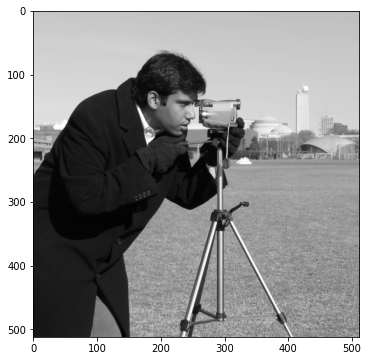

In [3]:
img = imageio.imread('imageio:camera.png')/255

plt.figure(figsize=(6, 6))
plt.imshow(img, 'gray')
plt.show()

## **1. Downsampling**

### **1.1. Nearest neighbour (NN) X2**

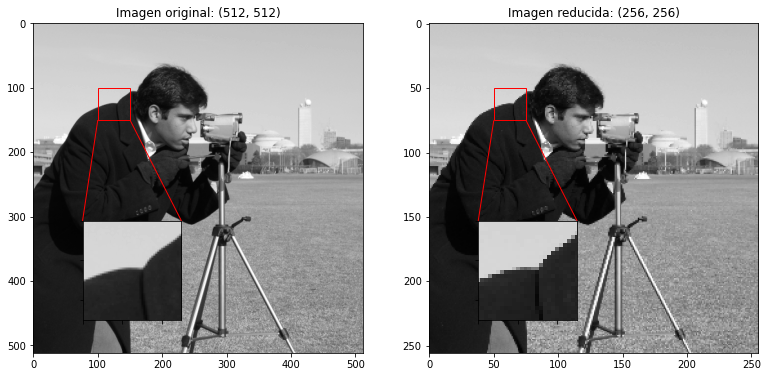

In [4]:
def nn_downsampling_x2(image):
    '''
    Downsampling de vecino más cercano (nn) con
    una cuadrícula de 2x2.
    '''
    return image[::2, ::2]

# ---------------------   Prueba nn_downsampling_x2   ---------------------
new_img = nn_downsampling_x2(img)

fig, ax = plt.subplots(1, 2, figsize=(13, 13))

display_zoom(img, ax[0])
display_zoom(new_img, ax[1])

ax[0].set_title(f"Imagen original: {img.shape}")
ax[1].set_title(f"Imagen reducida: {new_img.shape}")

plt.show()

### **1.2. Average 2X2**

**Referencias:**
* [Subsampling/averaging 1D | Stackoverflow](https://stackoverflow.com/questions/10847660/subsampling-averaging-over-a-numpy-array)
* [Downsample by function | Skimage](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.block_reduce)

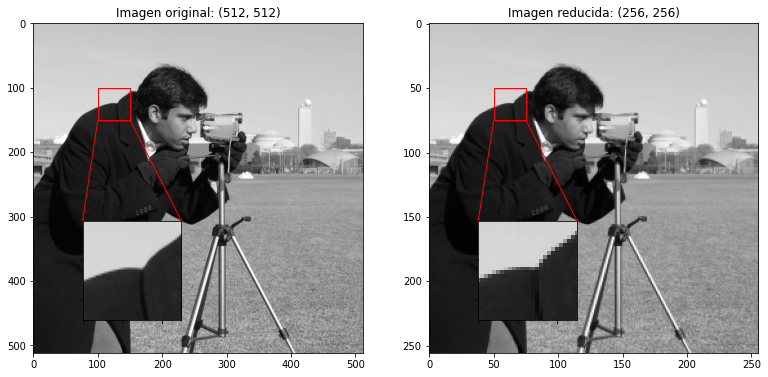

In [5]:
def avg_downsampling(image, block_size, cval=0): 
    '''
    Aplica downsampling a una imagen con el tamaño de ventana de `block_size`
    
    Entradas
    --------
    image: ndarray
           imagen a la cual se aplica el downsampling
    
    block_size: tuple
                tamaño de la ventana con que se aplica el downsampling
    
    cval: int
          valor a rellenar con padding
    '''

    # Verifica si el tamaño de la imagen encaja con el tamaño del 
    # bloque `block_size`. Si no encaja, calcula el número de paddings 
    # que se debe añadir para cada eje
    pad_width = []
    for i in range(len(block_size)):

        # La imagen en el eje `i` no encaja para el 
        #tamaño del bloque en el eje `i`
        if image.shape[i] % block_size[i] != 0:
            after_width = block_size[i] - (image.shape[i] % block_size[i])

        # La imagen en el eje `i` encaja en el bloque
        else:
            after_width = 0

        # Agrega la cantidad de padding que se debe anexar a la imagen
        pad_width.append((0, after_width))

    # Añade el padding a cada eje con un valor de `cval`
    image = np.pad(image, pad_width=pad_width, 
                   mode='constant', constant_values=cval)

    # Convierte el shape de la imagen y del bloque en arrays
    img_shape = np.array(image.shape)
    block_shape = np.array(block_size)

    # Descompone la imagen en ventanas del tamaño de `block_size`
    new_shape = tuple(img_shape // block_shape) + tuple(block_shape)
    new_strides = tuple(image.strides * block_shape) + image.strides
    image_blocks = np.lib.stride_tricks.as_strided(image, shape=new_shape, strides=new_strides)

    # Aplica la funcion deseada, en este caso AVERAGE
    func = np.average
    
    return func(image_blocks, axis=tuple(range(image.ndim, image_blocks.ndim)))

# ---------------------   Prueba avg_downsampling   ---------------------
new_img = avg_downsampling(img, (2, 2))

fig, ax = plt.subplots(1, 2, figsize=(13, 13))

display_zoom(img, ax[0])
display_zoom(new_img, ax[1])

ax[0].set_title(f"Imagen original: {img.shape}")
ax[1].set_title(f"Imagen reducida: {new_img.shape}")

plt.show()

### **1.3. Gaussian Filter + Nearest neighbour (NN) X2**

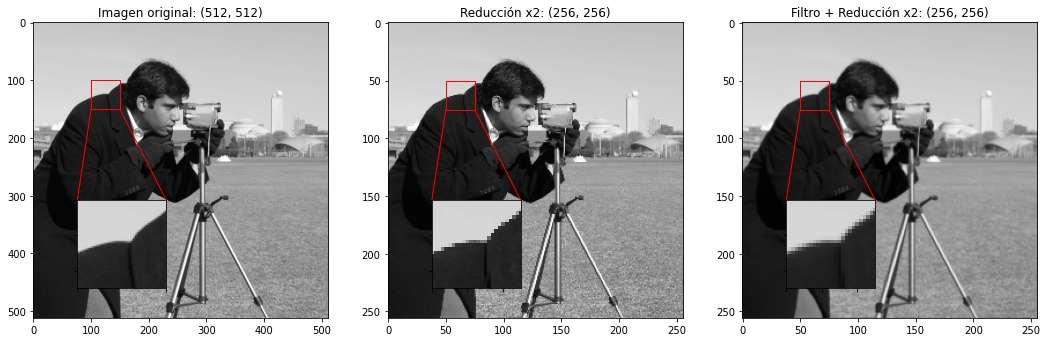

In [6]:
def gaussian_nn_downsampling_x2(image, std=1):
    '''
    Downsampling de vecino más cercano (nn) con
    una cuadrícula de 2x2 seguido de la aplicación
    de un filtro gaussiano con una `std`.
    '''
    img_filtered = gaussian(image, std)
    return nn_downsampling_x2(img_filtered)

# ---------------------   Prueba gaussian_nn_downsampling_x2   ---------------------
new_img1 = nn_downsampling_x2(img)
new_img2 = gaussian_nn_downsampling_x2(img, 1)

fig, ax = plt.subplots(1, 3, figsize=(18, 18))

display_zoom(img, ax[0])
display_zoom(new_img1, ax[1])
display_zoom(new_img2, ax[2])

ax[0].set_title(f"Imagen original: {img.shape}")
ax[1].set_title(f"Reducción x2: {new_img1.shape}")
ax[2].set_title(f"Filtro + Reducción x2: {new_img2.shape}")

plt.show()

## **2. Upsampling**

### **2.1. Nearest neighbour (NN) 2X2**

**Referencias:**
* [Kronecker product of two arrays | Numpy](https://numpy.org/doc/stable/reference/generated/numpy.kron.html)
* [Producto de Kronecker | Wikipedia](https://es.wikipedia.org/wiki/Producto_de_Kronecker?oldformat=true)
* [Imagen de ejemplo](https://www.giassa.net/wp-content/uploads/2009/12/cloning.png)

![](https://www.giassa.net/wp-content/uploads/2009/12/cloning.png)

Para lograr este tipo de Upsampling, se implementa el producto Kronecker, el cual se define de la siguiente manera:

>Supóngase que $A$ es una matriz de $n \times m$ y $B$ una matriz de $p \times q$ entonces el producto de Kronecker $A \otimes B$ es una matriz de tamaño $np \times mq$.

$$
\begin{bmatrix} 
    a_{11} & a_{12} & \cdots & a_{1m} \\ 
    a_{21} & a_{22} & \cdots & a_{2m} \\ 
    \vdots & \vdots & \ddots & a_{3m} \\ 
    a_{n1} & a_{n2} & \cdots & a_{nm} \\ 
\end{bmatrix} 
\otimes
\begin{bmatrix} 
    b_{11} & b_{12} \\ 
    b_{21} & b_{22} \\ 
\end{bmatrix} 
=
\begin{bmatrix} 
    a_{11}b_{11} & a_{11}b_{12} & \cdots & a_{1m}b_{11} & a_{1m}b_{21} \\ 
    a_{11}b_{21} & a_{11}b_{22} & \cdots & a_{1m}b_{12} & a_{1m}b_{22} \\ 
    \vdots       & \vdots       & \ddots & \vdots       & \vdots \\ 
    a_{n1}b_{11} & a_{n1}b_{12} & \cdots & a_{nm}b_{11} & a_{nm}b_{21}\\
    a_{n1}b_{21} & a_{n1}b_{22} & \cdots & a_{nm}b_{21} & a_{nm}b_{22} \\
\end{bmatrix} 
$$

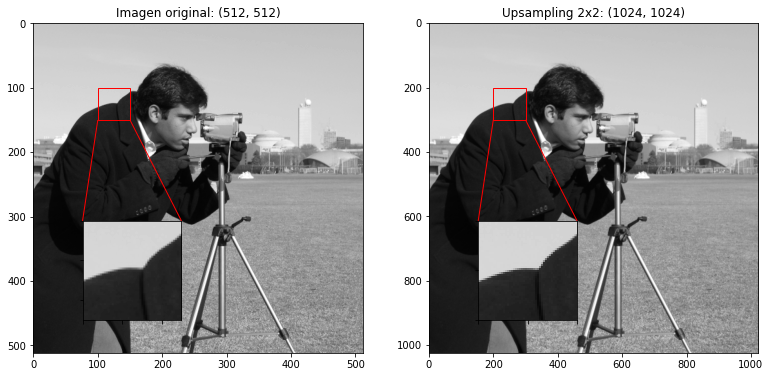

In [7]:
def nn_upsampling_x2(image):
    '''
    Upsampling de vecino más cercano (nn) con
    una cuadrícula de 2x2.
    '''
    # La matrix de unos `np.ones` varia su 
    # tamaño según la nueva resolución deseada
    return np.kron(image, np.ones((2, 2)))

# ---------------------   Prueba nn_upsampling_x2   ---------------------
new_img = nn_upsampling_x2(img)

fig, ax = plt.subplots(1, 2, figsize=(13, 13))

display_zoom(img, ax[0])
display_zoom(new_img, ax[1])

ax[0].set_title(f"Imagen original: {img.shape}")
ax[1].set_title(f"Upsampling 2x2: {new_img.shape}")

plt.show()

### **2.2. Bilinear**

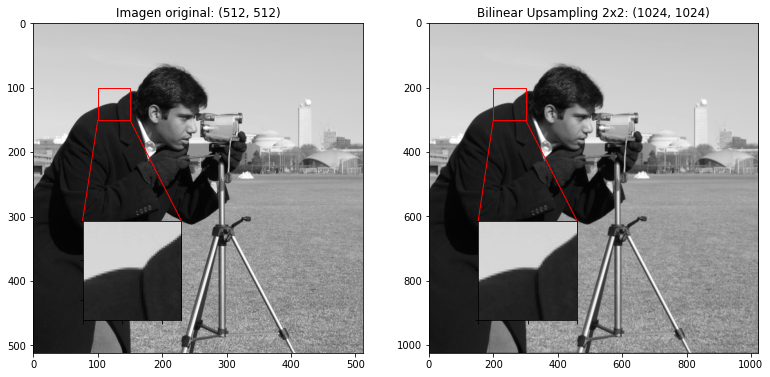

In [8]:
def bilinear_upsampling_x2(image):
    '''
    Upsampling bilineal con
    una cuadrícula de 2x2.
    '''
    # Agrega ceros a los vecinos de cada pixel
    matrix = np.zeros((2, 2))
    matrix[0, 0] = 1
    new_img = np.kron(image, matrix)

    kernel = np.array([[1/4, 1/2, 1/4], 
                       [1/2,  1,  1/2],
                       [1/4, 1/2, 1/4]])
    
    return convolve2d(new_img, kernel, 'same')

# ---------------------   Prueba bilinear_upsampling_x2   ---------------------
new_img = bilinear_upsampling_x2(img)

fig, ax = plt.subplots(1, 2, figsize=(13, 13))

display_zoom(img, ax[0])
display_zoom(new_img, ax[1])

ax[0].set_title(f"Imagen original: {img.shape}")
ax[1].set_title(f"Bilinear Upsampling 2x2: {new_img.shape}")

plt.show()

### **2.3. Bicubic**

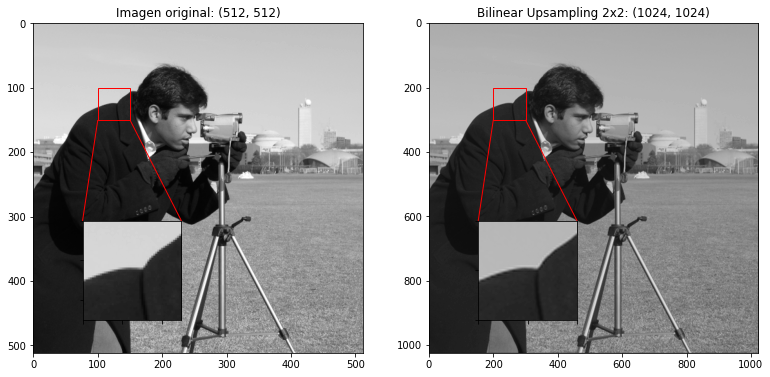

In [9]:
def bicubic_upsampling_x2(image):
    '''
    Upsampling bicúbica con
    una cuadrícula de 2x2.
    '''
    # Agrega ceros a los vecinos de cada pixel
    matrix = np.zeros((2, 2))
    matrix[0, 0] = 1
    new_img = np.kron(image, matrix)
    
    window = [-1/8, 0, 5/8, 1, 5/8, 0, -1/8]
    kernel = np.outer(window, window)
    
    return convolve2d(new_img, kernel, 'same')

# ---------------------   Prueba bicubic_upsampling_x2   ---------------------
new_img = bicubic_upsampling_x2(img)

fig, ax = plt.subplots(1, 2, figsize=(13, 13))

display_zoom(img, ax[0])
display_zoom(new_img, ax[1])

ax[0].set_title(f"Imagen original: {img.shape}")
ax[1].set_title(f"Bilinear Upsampling 2x2: {new_img.shape}")

plt.show()

### **2.4. Nearest neighbour (NN) X2 + Gaussian Filter****

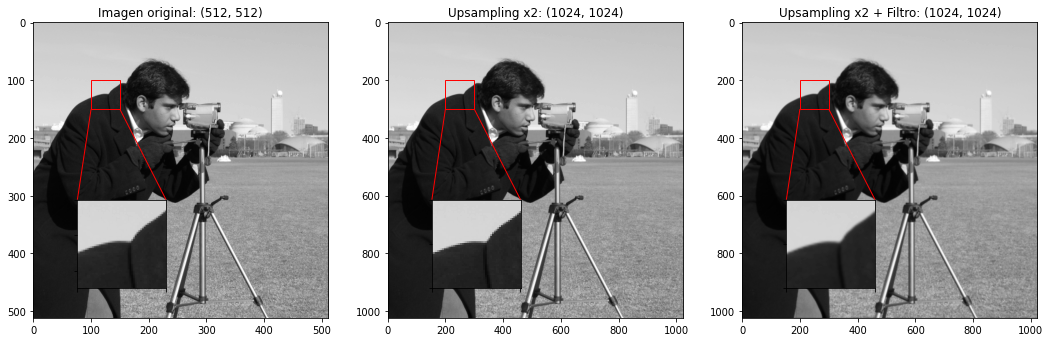

In [10]:
def gaussian_nn_upsampling_x2(image, std):
    '''
    Upsampling de vecino más cercano (nn) con
    una cuadrícula de 2x2 seguido de la aplicación
    de un filtro gaussiano con sigma igual a `std`.
    '''
    new_img = nn_upsampling_x2(image)
    return gaussian(new_img, std)

# ---------------------   Prueba bicubic_upsampling_x2   ---------------------
new_img1 = nn_upsampling_x2(img)
new_img2 = gaussian_nn_upsampling_x2(img, 1)

fig, ax = plt.subplots(1, 3, figsize=(18, 18))

display_zoom(img, ax[0])
display_zoom(new_img1, ax[1])
display_zoom(new_img2, ax[2])

ax[0].set_title(f"Imagen original: {img.shape}")
ax[1].set_title(f"Upsampling x2: {new_img1.shape}")
ax[2].set_title(f"Upsampling x2 + Filtro: {new_img2.shape}")

plt.show()

## **3. Resampling using Fast Fourier Transform (FFT)**

**Referencias:**
* [Resample | Scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html)

### **3.1. Downsampling - FFT**

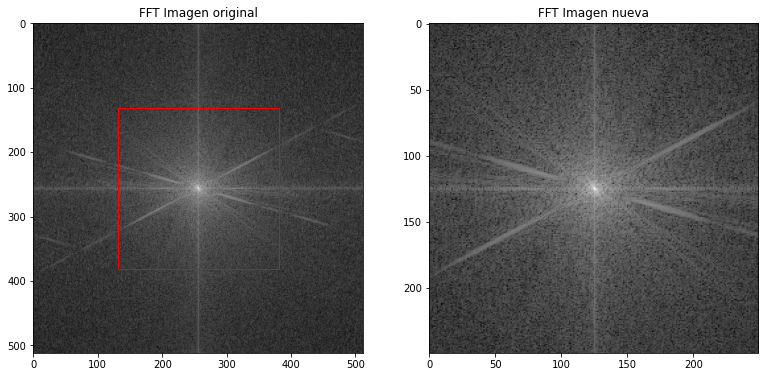

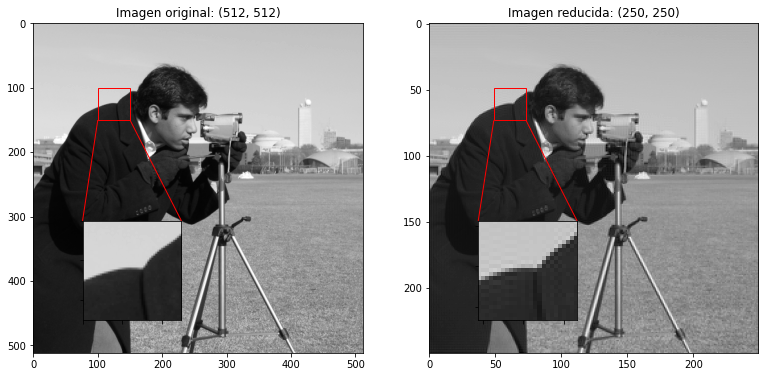

In [11]:
def plot_downsampling(image1, image2, crop_points, ax_index=0):
    '''
    Recibe dos espectros y grafica un cuadrilatero 
    rojo en la imagen de indice `ax_index` (0: image1, 1: image2)
    
    `crop_points` son los puntos del cuadrilatero sobre la imagen.
    '''
    
    img1_mag = np.log(np.abs(image1) + 1)
    img2_mag = np.log(np.abs(image2) + 1)
    
    fig, axs = plt.subplots(1, 2, figsize=(13, 13))
    
    axs[0].imshow(img1_mag, 'gray')
    axs[1].imshow(img2_mag, 'gray')
    
    if crop_points is not None:
        
        top, bottom, left, right = crop_points
        
        # Crea el rectangulo
        rect = patches.Rectangle(xy=(top, left), 
                                 width=(right-left), 
                                 height=(bottom - top), 
                                 linewidth=1, 
                                 edgecolor='r', 
                                 facecolor='none')

        # Añade el rectangulo al eje `axs[ax_index]`
        axs[ax_index].add_patch(rect)
    
    axs[0].set_title("FFT Imagen original")
    axs[1].set_title("FFT Imagen nueva")
    
    plt.show()

    
def fft_downsampling(image, new_shape):
    '''
    Aplica Downsampling a una imagen con un 
    solo canal (en escala de grises) usando FFT.
    '''
    
    height, width = image.shape
    new_height, new_width = new_shape
    
    # cociente, residuo = divmod(a, b)
    top = sum(divmod(height - new_height, 2))
    bottom = sum(divmod(height + new_height, 2))
    left = sum(divmod(width - new_width, 2))
    right = sum(divmod(width + new_width, 2))
    
    # FFT de la imagen
    img_fft = np.fft.fftshift(np.fft.fft2(image))
    
    # Toma un segmento del tamaño de `new_shape` en el centro de la FFT
    new_img_fft = img_fft[top:bottom, left:right]
    
    # Visualiza el crop realizado a la FFT de la imagen
    plot_downsampling(img_fft, new_img_fft, (top, bottom, left, right))
    
    return np.fft.ifft2(np.fft.ifftshift(new_img_fft)).real

# ---------------------   Prueba fft_downsampling   ---------------------
new_img = fft_downsampling(img, (250, 250))

fig, ax = plt.subplots(1, 2, figsize=(13, 13))

display_zoom(img, ax[0])
display_zoom(new_img, ax[1])

ax[0].set_title(f"Imagen original: {img.shape}")
ax[1].set_title(f"Imagen reducida: {new_img.shape}")

plt.show()

### **3.2. Upsampling - FFT**

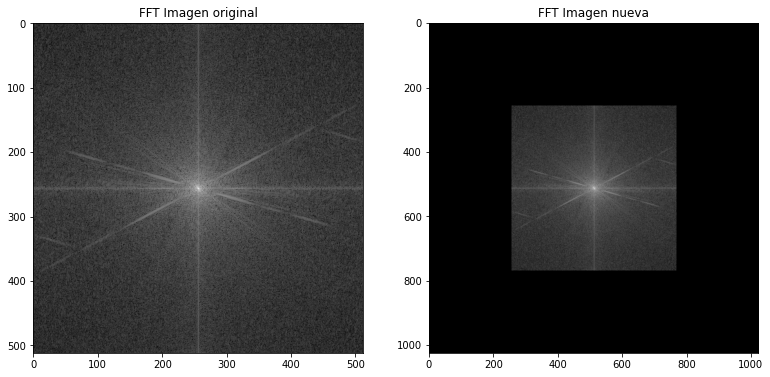

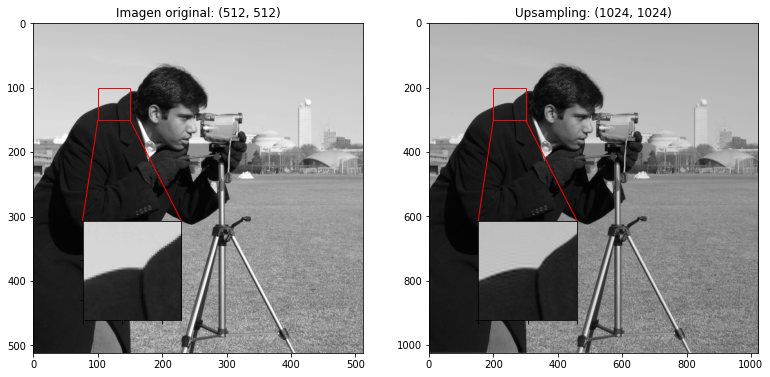

In [12]:
def fft_upsampling(image, new_shape):
    '''
    Aplica Upsampling a una imagen con un 
    solo canal (en escala de grises) usando FFT.
    '''
    img_fft = np.fft.fftshift(np.fft.fft2(image))
    
    # Tamaño del padding
    pad_height = new_shape[0] - image.shape[0]
    pad_width = new_shape[1] - image.shape[1]
    
    pad_axs = []
    pad_axs.append((sum(divmod(pad_height, 2)), pad_height//2))
    pad_axs.append((sum(divmod(pad_width, 2)), pad_width//2))
    
    new_img_fft = np.pad(img_fft, pad_width=pad_axs, mode='constant', constant_values=0)
    
    height, width = img_fft.shape
    new_height, new_width = new_img_fft.shape
    
    # cociente, residuo = divmod(a, b)
    top = sum(divmod(height - new_height, 2))
    bottom = sum(divmod(height + new_height, 2))
    left = sum(divmod(width - new_width, 2))
    right = sum(divmod(width + new_width, 2))
    
    plot_downsampling(img_fft, new_img_fft, None)
    
    return np.abs(np.fft.ifft2(new_img_fft))

# ---------------------   Prueba fft_downsampling   ---------------------
new_shape = (img.shape[0]*2, img.shape[1]*2)
new_img = fft_upsampling(img, new_shape)

fig, ax = plt.subplots(1, 2, figsize=(13, 13))
display_zoom(img, ax[0])
display_zoom(new_img, ax[1])

ax[0].set_title(f"Imagen original: {img.shape}")
ax[1].set_title(f"Upsampling: {new_img.shape}")

plt.show()

## **3. Quantization**

## **Imagen de prueba #2**

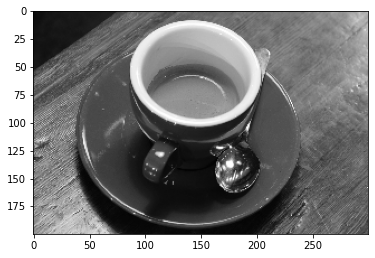

In [13]:
img = imageio.imread('imageio:coffee.png').mean(axis=2)/255
img = nn_downsampling_x2(img)

plt.figure(figsize=(6, 6))
plt.imshow(img, 'gray')
plt.show()

### **3.1. Uniform**

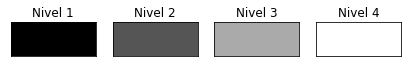

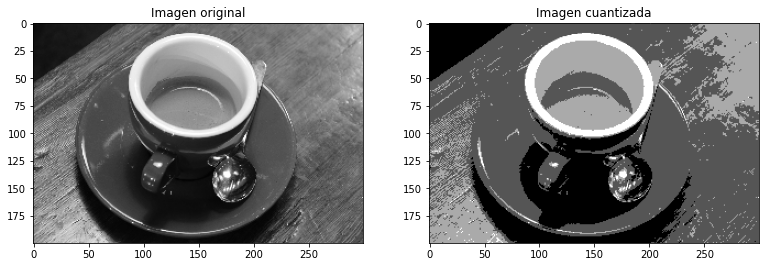

In [14]:
def plot_levels(level_values):
    '''
    Grafica una grilla con rectángulos en escala 
    de grises correspondientes a cada valor float 
    en `level_values`. 
    '''

    fig, axs = plt.subplots(1, len(level_values), figsize=(7, 7))

    for index in range(len(level_values)):

        rectangle = np.ones((4, 10)) * level_values[index]

        axs[index].yaxis.set_visible(False)
        axs[index].xaxis.set_visible(False)

        axs[index].imshow(rectangle, cmap='gray', vmin=0, vmax=1)

        axs[index].set_title(f"Nivel {index + 1}")

    plt.show()

def quantize_uniform(image, levels, show_leves=False):
    '''
    Cuantización uniforma a una imagen con una cantidad 
    de niveles `levels`.
    
    `show_levels` permite grafical cada uno de los colores
    según la cantidad de niveles ingresados.
    '''
    new_img = np.round(image * (levels - 1)) / (levels - 1)
    
    if show_leves:
        plot_levels(np.unique(new_img))
        
    return new_img

# ---------------------   Prueba cuantize_uniform   ---------------------
new_img = quantize_uniform(img, levels=4, show_leves=True)

fig, ax = plt.subplots(1, 2, figsize=(13, 13))

ax[0].imshow(img, 'gray')
ax[1].imshow(new_img, 'gray')

ax[0].set_title(f"Imagen original")
ax[1].set_title(f"Imagen cuantizada")

plt.show()

### **3.2. Dithering Scanline**

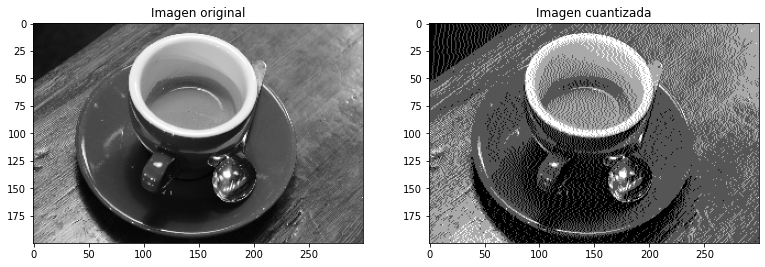

In [15]:
def quantize_dithering_scanline(image, levels):
    '''
    Cuantización por difusión de error <Scanline> 
    a una imagen con una cantidad de niveles `levels`.
    '''
    img_height, img_width = image.shape
    out = np.zeros(image.shape)
    
    for row in range(img_height):
        error=0
        for col in range(img_width):
            out[row, col] = round(image[row, col] * (levels-1) + error)/(levels-1)
            error = error - out[row, col] + image[row, col]
            
    return out

# ---------------------   Prueba quantize_dithering_scanline   ---------------------
new_img = quantize_dithering_scanline(img, levels=4)

fig, ax = plt.subplots(1, 2, figsize=(13, 13))

ax[0].imshow(img, 'gray')
ax[1].imshow(new_img, 'gray')

ax[0].set_title(f"Imagen original")
ax[1].set_title(f"Imagen cuantizada")

plt.show()

### **3.3. Dithering Floyd - Steinberg**

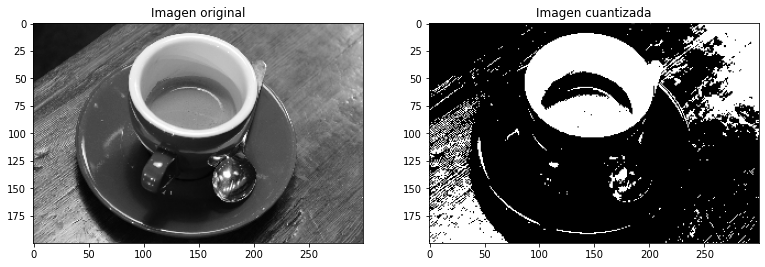

In [16]:
def quantize_floyd_steinberg(image, levels):
    '''
    Cuantización por difusión de error <Floyd-Steinberg> 
    a una imagen con una cantidad de niveles `levels`.
    '''
    img_height, img_width = image.shape
    out = np.zeros(image.shape)
    
    for row in range(img_height):
        for col in range(img_width):
            old_pixel = image[row, col]
            new_pixel = round(image[row, col] * (levels-1))/(levels-1)
            
            out[row, col] = new_pixel
            
            error = old_pixel - new_pixel
            
            if (col + 1) < img_width:
                out[row, col + 1] += error * (7/16) # right
            
            if (row + 1 < img_height) and (col + 1 < img_width):
                out[row + 1, col + 1] += error * (1/16) # right, down
            
            if (row + 1) < img_height:
                out[row + 1, col] += error * (5/16) # down
            
            if (col - 1 >= 0) and (row + 1 < img_height): 
                out[row + 1, col - 1] += error * (3/16) # left, down
            
    return out

# ---------------------   Prueba quantize_floyd_steinberg   ---------------------
new_img = quantize_floyd_steinberg(img, levels=2)

fig, ax = plt.subplots(1, 2, figsize=(13, 13))

ax[0].imshow(img, 'gray')
ax[1].imshow(new_img, 'gray')

ax[0].set_title(f"Imagen original")
ax[1].set_title(f"Imagen cuantizada")

plt.show()